In [71]:
%matplotlib inline
import sys 
sys.path.append('..')
import matplotlib
import mglearn
import os

from preamble import *
#plt.rcParams['image.cmap'] = "gray"

from matplotlib.pyplot import rc
rc('font',family='New Gulim') #plot 한글폰트 적용

In [3]:
from sklearn.datasets import make_blobs #군집용 데이터 셋
from sklearn.datasets import make_moons

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_lfw_people

In [74]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import dendrogram, ward

In [83]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

In [87]:
## 흑백 얼굴 이미지를 이용한 데이터 처리 코드

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 사이로 스케일 조정합니다.
# (옮긴이) MinMaxScaler를 적용하는 것과 거의 동일합니다.
X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
nmf = NMF(n_components=100, random_state=0)
nmf.fit(X_train)
pca = PCA(n_components=100, random_state=0)
pca.fit(X_train)
kmeans = KMeans(n_clusters=100, random_state=0)
kmeans.fit(X_train)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(X_test)]
X_reconstructed_nmf = np.dot(nmf.transform(X_test), nmf.components_)

### 3.5.3 군집 알고리즘의 비교와 평가

#### 타겟값으로 군집 평가하기

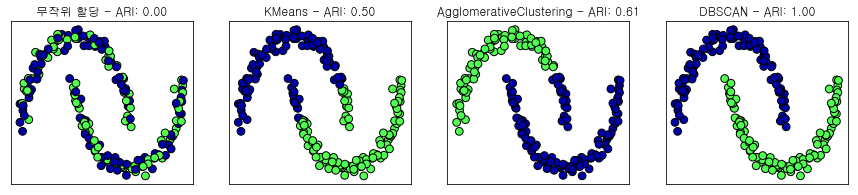

In [53]:
#타겟값으로 군집 평가하기
from sklearn.metrics.cluster import adjusted_rand_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일을 조정합니다
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 사용할 알고리즘 모델을 리스트로 만듭니다
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# 비교를 위해 무작위로 클러스터 할당을 합니다
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터를 그립니다
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title("무작위 할당 - ARI: {:.2f}".format(
        adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # 클러스터 할당과 클러스터 중심을 그립니다
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

In [54]:
from sklearn.metrics import accuracy_score

# 포인트가 클러스터로 나뉜 두 가지 경우
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# 모든 레이블이 달라졌으므로 정확도는 0입니다
print("정확도: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# 같은 포인트가 클러스터에 모였으므로 ARI는 1입니다
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

정확도: 0.00
ARI: 1.00


#### 타겟값 없이 군집 평가하기

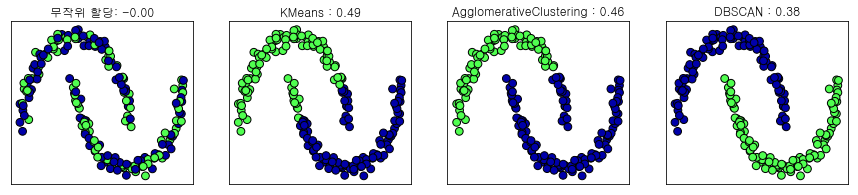

In [39]:
from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# 평균이 0, 분산이 1이 되도록 데이터의 스케일을 조정합니다
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 비교를 위해 무작위로 클러스터 할당을 합니다
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

# 무작위 할당한 클러스터를 그립니다
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title("무작위 할당: {:.2f}".format(
        silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # 클러스터 할당과 클러스터 중심을 그립니다
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60, edgecolors='black')
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

#### 얼굴 데이터셋으로 군집 알고리즘 비교

In [55]:
# LFW 데이터에서 고유얼굴을 찾은 다음 데이터를 변환합니다
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

#### DBSCAN으로 얼굴 데이터셋 분석

In [42]:
# 기본 매개변수로 DBSCAN을 적용합니다
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1]


In [43]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1]


In [44]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("고유한 레이블: {}".format(np.unique(labels)))

고유한 레이블: [-1  0]


In [45]:
# 잡음 포인트와 클러스터에 속한 포인트 수를 셉니다.
# bincount는 음수를 받을 수 없어서 labels에 1을 더했습니다.
# 반환값의 첫 번째 원소는 잡음 포인트의 수입니다.
print("클러스터별 포인트 수: {}".format(np.bincount(labels + 1)))

클러스터별 포인트 수: [  32 2031]


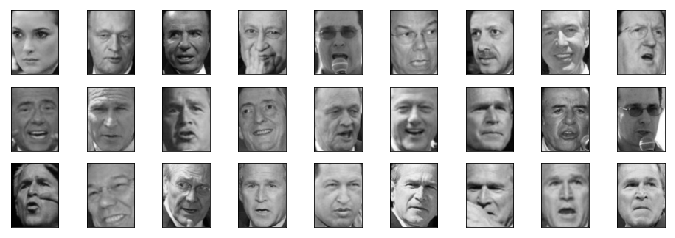

In [86]:
noise = X_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [47]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("클러스터 수: {}".format(len(np.unique(labels))))
    print("클러스터 크기: {}".format(np.bincount(labels + 1)))


eps=1
클러스터 수: 1
클러스터 크기: [2063]

eps=3
클러스터 수: 1
클러스터 크기: [2063]

eps=5
클러스터 수: 1
클러스터 크기: [2063]

eps=7
클러스터 수: 14
클러스터 크기: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
클러스터 수: 4
클러스터 크기: [1307  750    3    3]

eps=11
클러스터 수: 2
클러스터 크기: [ 413 1650]

eps=13
클러스터 수: 2
클러스터 크기: [ 120 1943]


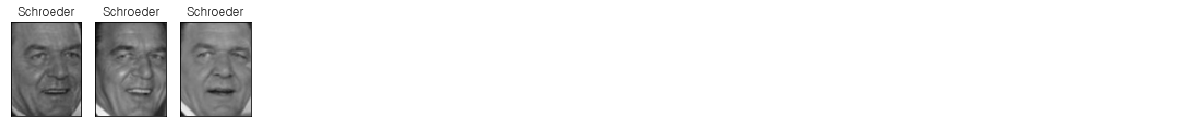

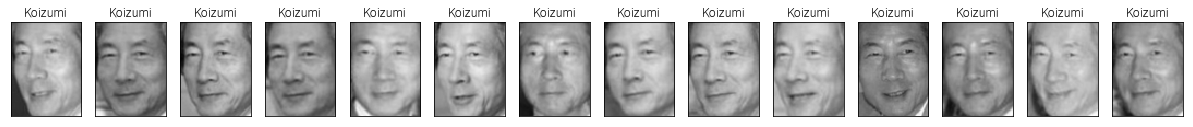

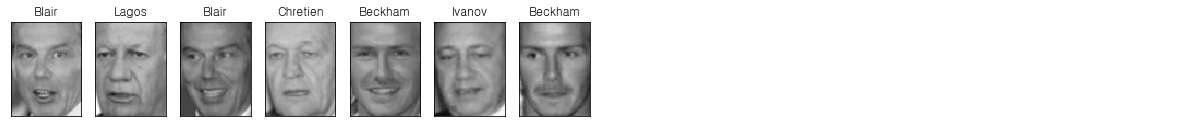

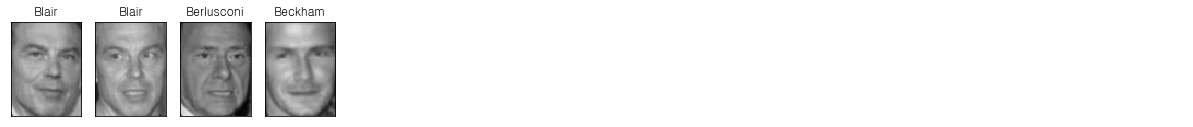

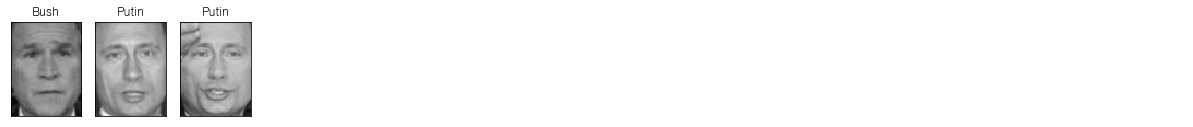

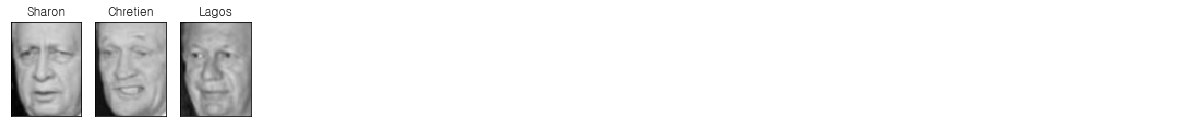

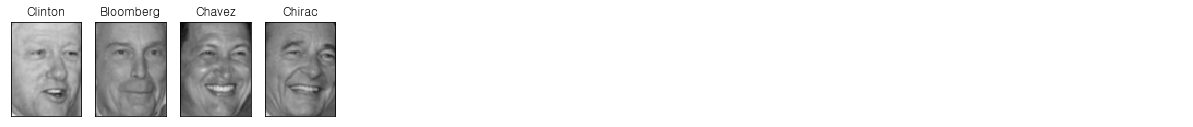

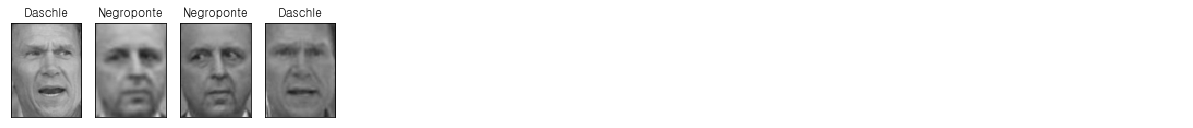

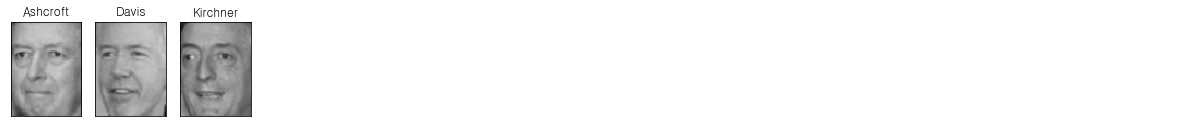

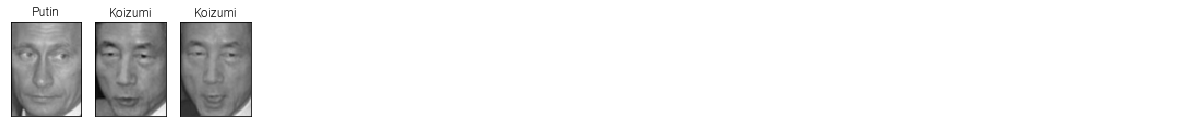

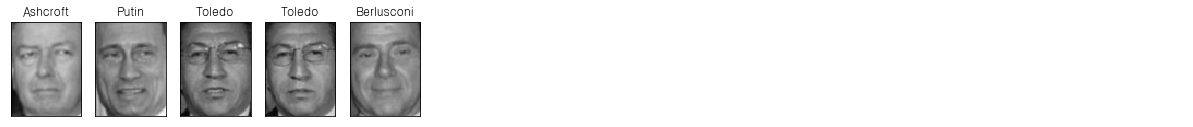

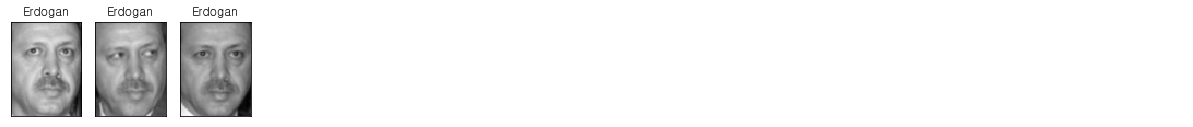

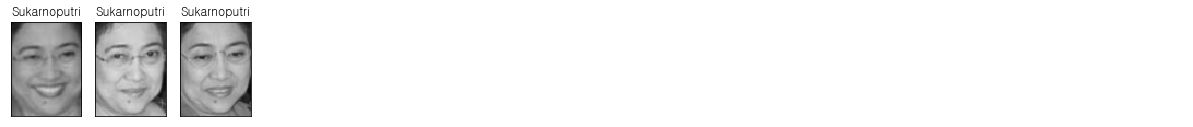

In [91]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    fig, axes = plt.subplots(1, 14, figsize=(14*1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    i = 0
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
        i += 1
    for j in range(len(axes) - i):
        axes[j+i].imshow(np.array([[1]*65]*87), vmin=0, vmax=1)
        axes[j+i].axis('off')

#### k-평균으로 얼굴 데이터셋 분석하기

In [92]:
n_clusters = 10
# k-평균으로 클러스터를 추출합니다
km = KMeans(n_clusters=n_clusters, random_state=0)
labels_km = km.fit_predict(X_pca)
print("k-평균의 클러스터 크기: {}".format(np.bincount(labels_km)))

k-평균의 클러스터 크기: [155 175 238  75 358 257  91 219 323 172]


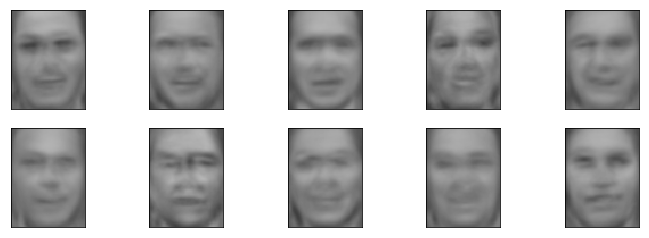

In [96]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1)

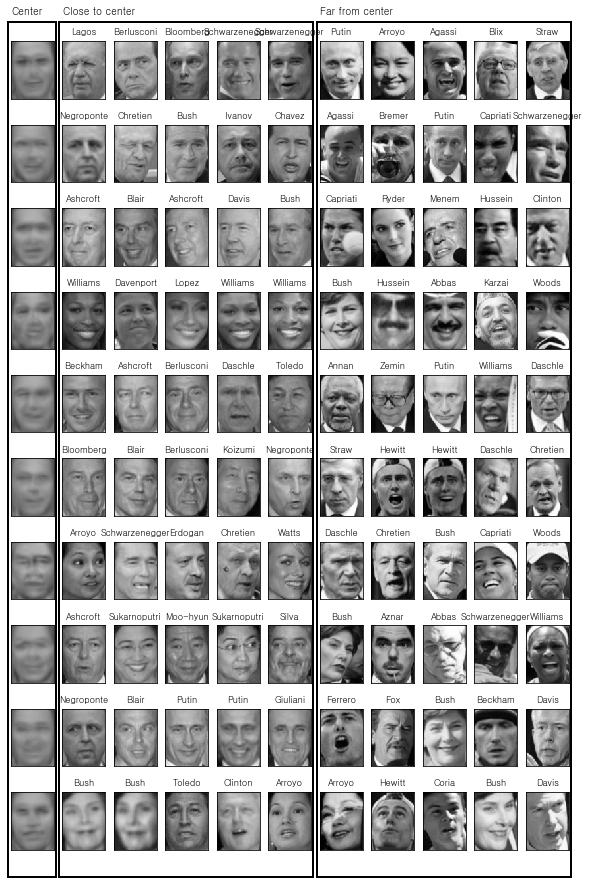

In [97]:
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, X_people,
                                y_people, people.target_names)

#### 병합 군집으로 얼굴 데이터셋 분석하기

In [69]:
# 병합 군집으로 클러스터를 추출합니다
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("병합 군집의 클러스터 크기: {}".format(
       np.bincount(labels_agg)))

병합 군집의 클러스터 크기: [169 660 144 329 217  85  18 261  31 149]


In [70]:
print("ARI: {:.2f}".format(adjusted_rand_score(labels_agg, labels_km)))

ARI: 0.09


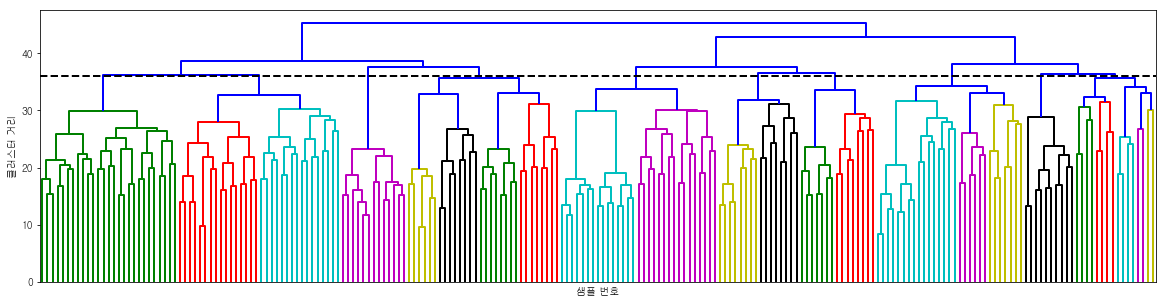

In [75]:
linkage_array = ward(X_pca)
# 클러스터 사이의 거리가 담겨있는 linkage_array로 덴드로그램을 그립니다
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("샘플 번호")
plt.ylabel("클러스터 거리")
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [36, 36], '--', c='k')

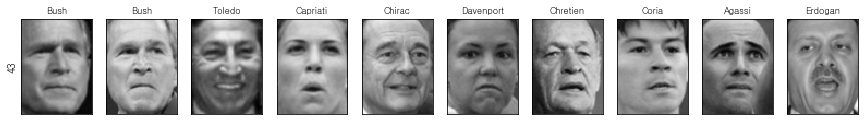

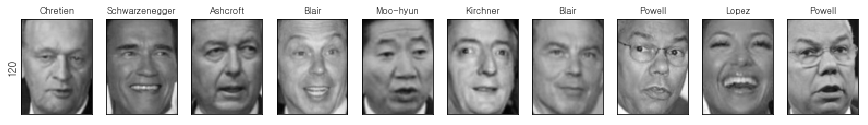

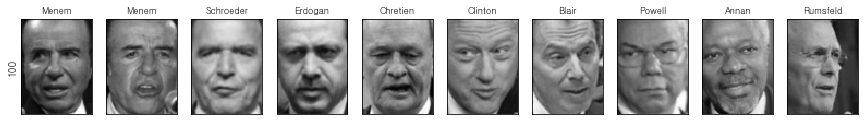

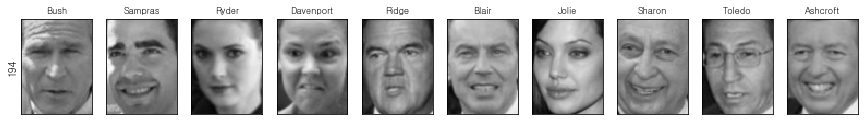

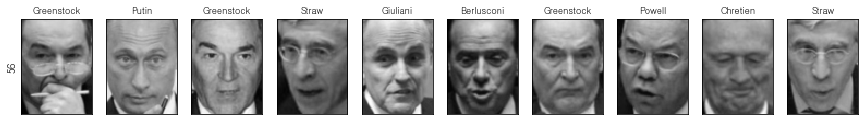

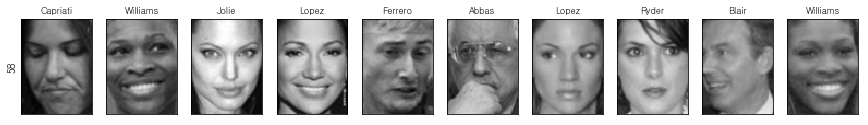

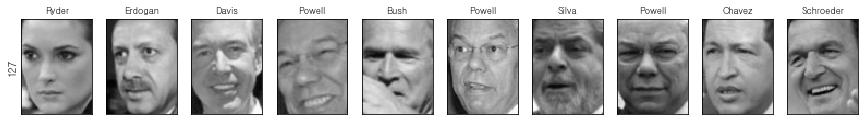

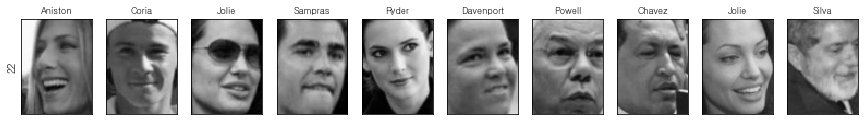

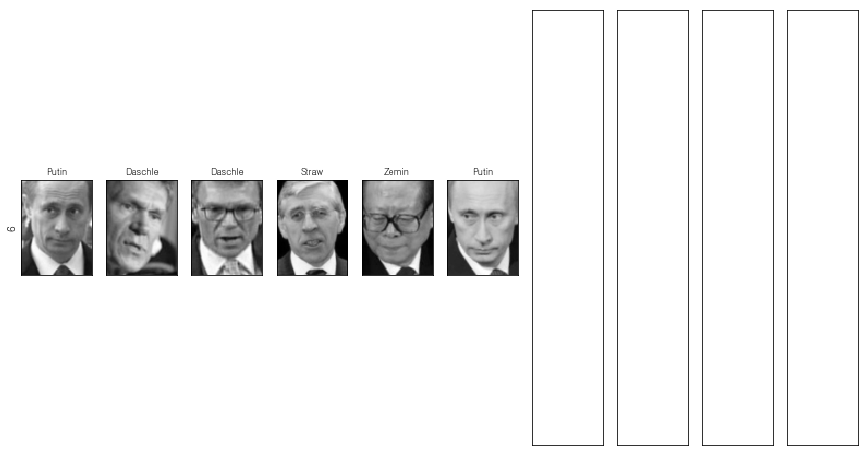

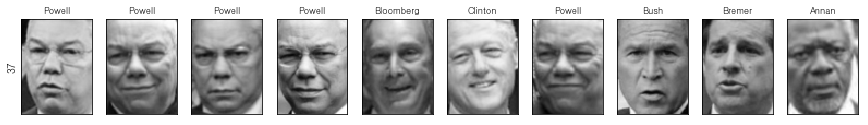

In [98]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})

병합 군집의 클러스터 크기: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


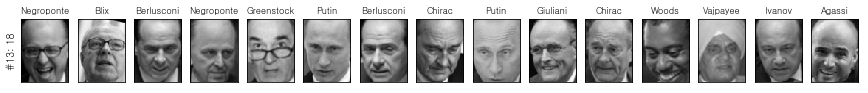

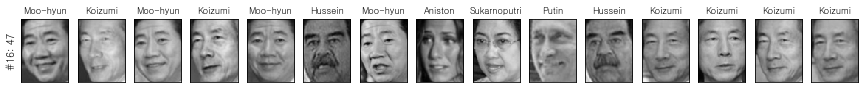

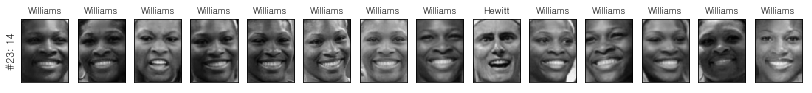

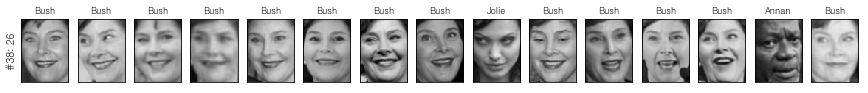

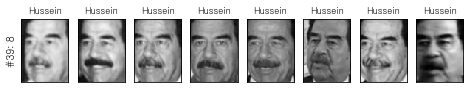

In [99]:
# 병합 군집으로 클러스터를 추출합니다
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("병합 군집의 클러스터 크기: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [13, 16, 23, 38, 39]: # 흥미로운 클러스터 몇개를 골랐습니다
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                      labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                     fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)